In [1]:
library(tidyverse)

── Attaching packages ────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────── tidyverse 1.3.0 ──

✔ ggplot2 3.3.3     ✔ purrr   0.3.4
✔ tibble  3.1.0     ✔ dplyr   1.0.5
✔ tidyr   1.1.3     ✔ stringr 1.4.0
✔ readr   1.4.0     ✔ forcats 0.5.1

── Conflicts ───────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()



In [2]:
scores <- read_tsv("../../analysis/kaggle/confidence_by_patient.tsv") %>%
    select(Id, set, score=confidence) %>%
    mutate(confidence=case_when(
        score <= .05 ~ "p05",
        score <= .10 ~ "p10",
        score <= .15 ~ "p15",
        TRUE ~ "rest",
    ))
metadata <- read_tsv("../../analysis/kaggle/patient_metadata.tsv")


── Column specification ───────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
cols(
  Id = col_character(),
  predicted_LVEDV = col_double(),
  predicted_LVESV = col_double(),
  predicted_LVEF = col_double(),
  true_LVEDV = col_double(),
  true_LVESV = col_double(),
  true_LVEF = col_double(),
  set = col_character(),
  sys_diff = col_double(),
  sys_perc = col_double(),
  dia_diff = col_double(),
  dia_perc = col_double(),
  confidence = col_double()
)



── Column specification ───────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
cols(
  .default = col_double(),
  PatientsAgeNum = col_character(),
  PatientsAgeUnit = col_character(),
  PatientsSex = col_character(),
  pid = col_character(),
  used = col_logical(),
  se

In [3]:
data <- left_join(metadata, scores, by=c("pid"="Id"))

In [4]:
theme_set(theme_minimal())
options(repr.plot.width = 8, repr.plot.res=200)

In [5]:
gdata <- data %>%
    rename(ESV=Systole, EDV=Diastole) %>%
    gather("measure","value",EF,ESV,EDV) %>%
    mutate(measure = fct_relevel(measure, "EF"))

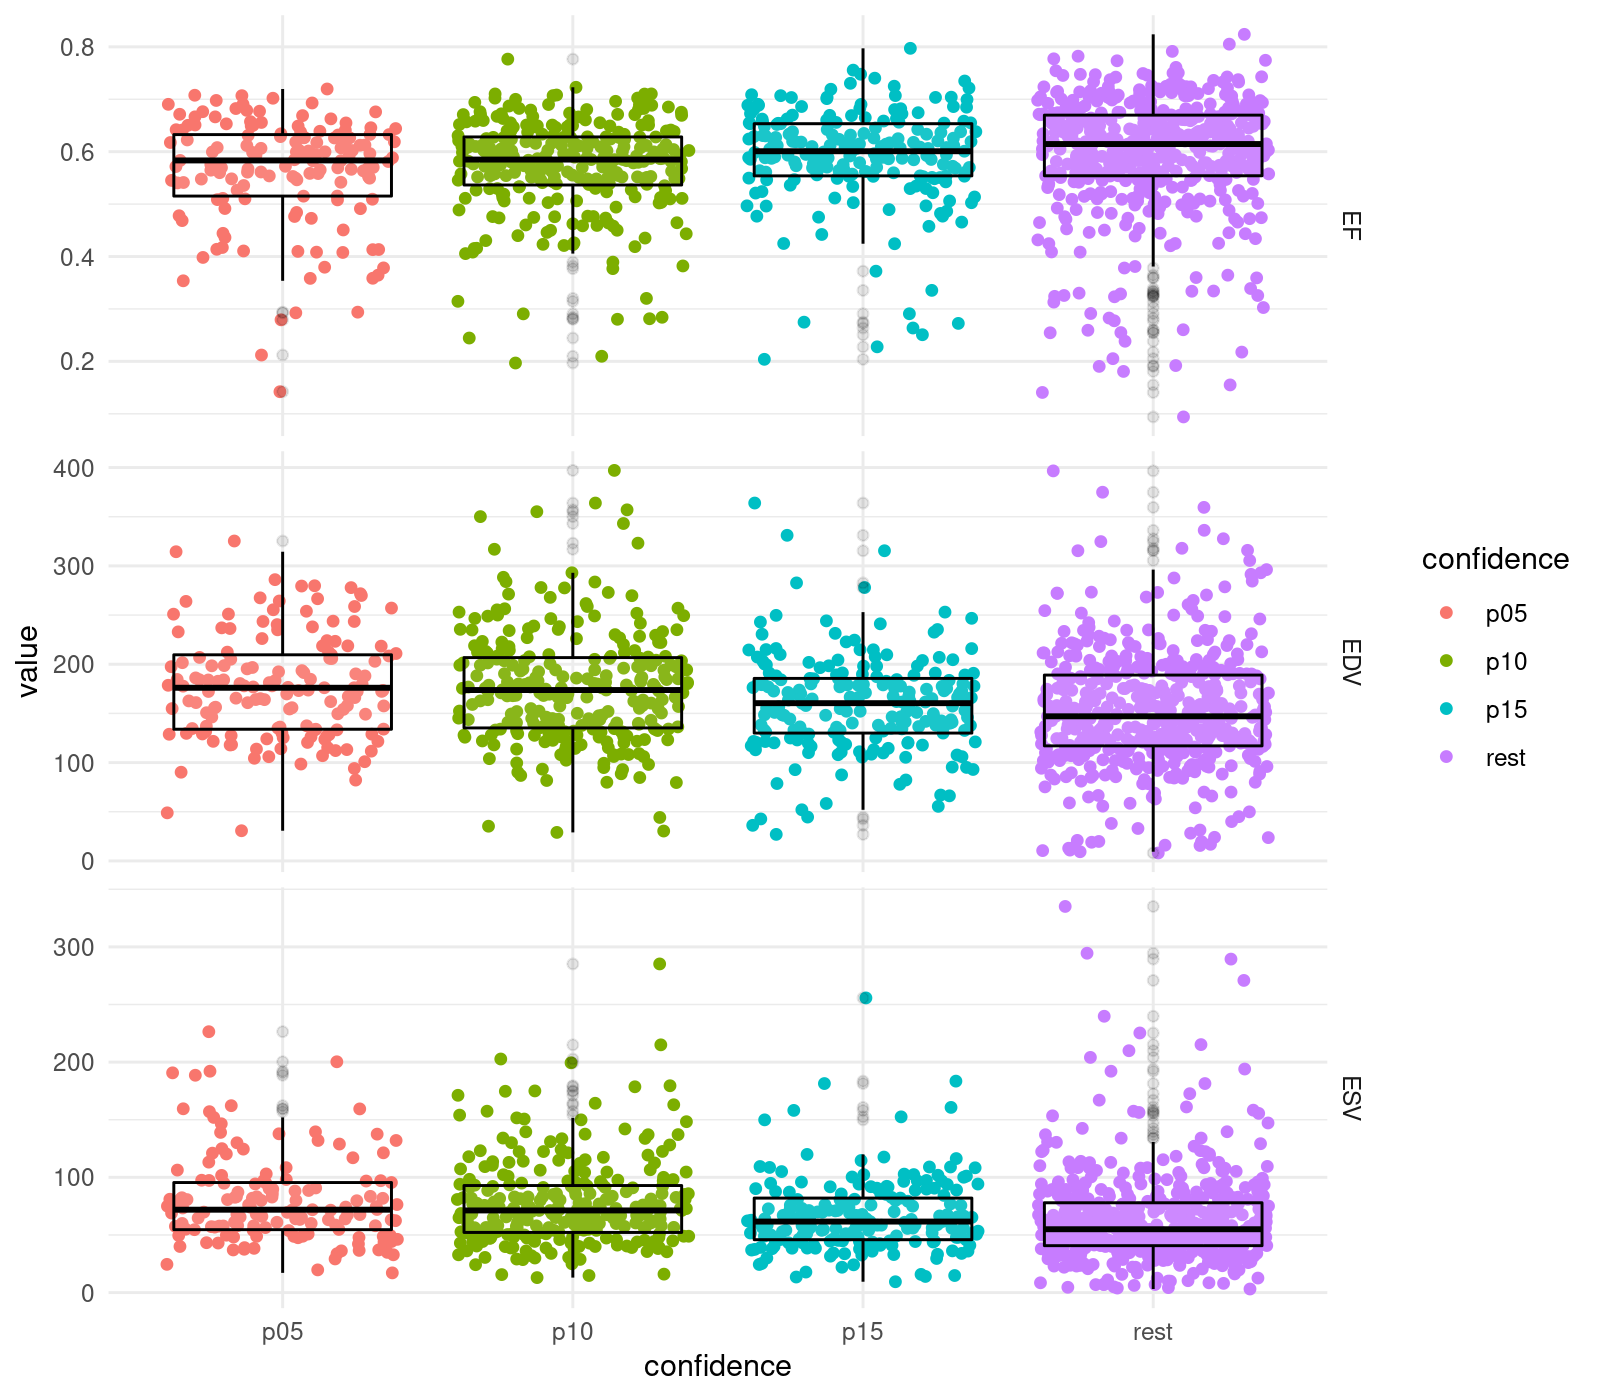

In [6]:
ggplot(gdata %>% filter(value<400), aes(x=confidence, y=value, color=confidence)) + geom_jitter() + geom_boxplot(color="black",alpha=.1) + facet_grid(measure ~ ., scale="free_y")

In [7]:
ggsave("fig_S1.png", width=10)
ggsave("fig_S1.tiff", width=10)
ggsave("fig_S1.svg", width=10)

Saving 10 x 6.67 in image

Saving 10 x 6.67 in image

Saving 10 x 6.67 in image



In [8]:
gdata %>%
    group_by(measure, confidence) %>%
    summarize(mean=mean(value), sd=sd(value), median=median(value)) %>%
    mutate_if(is.numeric, round, 2)
    #ungroup %>%
    #select(-sd,-median) %>%
    #pivot_wider(names_from = confidence, values_from=mean)

`summarise()` has grouped output by 'measure'. You can override using the `.groups` argument.

`mutate_if()` ignored the following grouping variables:
Column `measure`



measure,confidence,mean,sd,median
<fct>,<chr>,<dbl>,<dbl>,<dbl>
EF,p05,0.56,0.10,0.58
EF,p10,0.57,0.09,0.58
EF,p15,0.59,0.10,0.60
EF,rest,0.60,0.11,0.61
EDV,p05,177.49,53.67,176.10
EDV,p10,176.21,57.52,173.80
EDV,p15,159.49,50.08,160.40
EDV,rest,153.51,62.61,147.10
ESV,p05,80.26,38.89,71.90


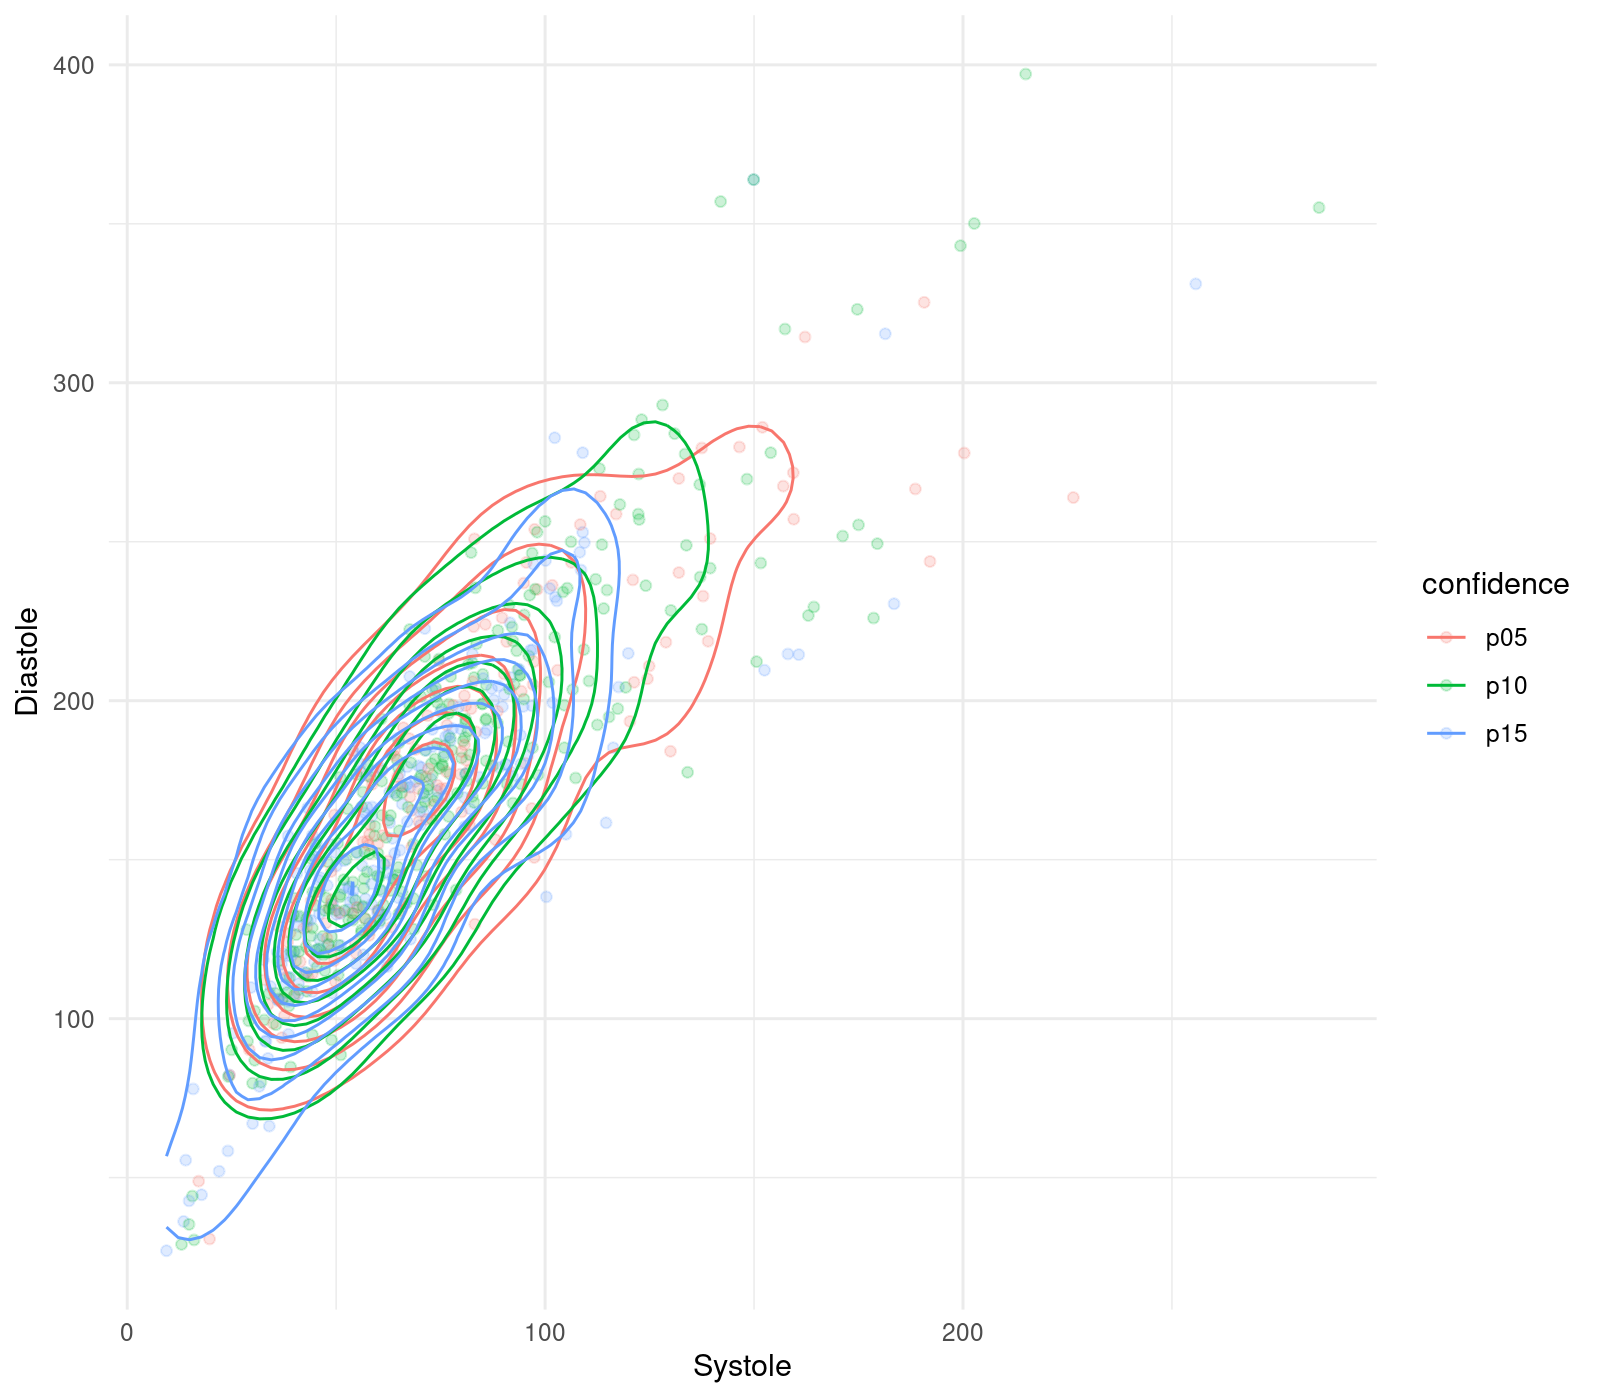

In [9]:
ggplot(data %>% filter(confidence != "rest"), aes(x=Systole, y=Diastole, color=confidence)) +
    geom_point(alpha=.2) +
    geom_density2d(adjust=1)
    #geom_hex()

In [10]:
metadata %>% colnames

[1] "PatientID"                  "PatientsAgeNum"            
 [3] "PatientsAgeUnit"            "PatientsSex"               
 [5] "pid"                        "Columns"                   
 [7] "Rows"                       "used"                      
 [9] "set"                        "EchoNumber"                
[11] "EchoTime"                   "EchoTrainLength"           
[13] "FlipAngle"                  "PhaseEncodingDirection"    
[15] "MagneticFieldStrength"      "ModelName"                 
[17] "NumberOfAverages"           "NumberOfPhaseEncodingSteps"
[19] "PercentSampling"            "PixelBandwidth"            
[21] "PixelRepresentation"        "PixelSpacing"              
[23] "RepetitionTime"             "ScanningSequence"          
[25] "SequenceName"               "SequenceVariant"           
[27] "SliceThickness"             "SoftwareVersion"           
[29] "dBdt"                       "PatientsAgeYears"          
[31] "X"                          "Y"                         
[33] "pixelSpacingX"              "pixelSpacingY"             
[35] "sliceSpacing"               "scaleFactor"               
[37] "inconsistentMetadata"       "Systole"                   
[39] "Diastole"                   "EF"

In [11]:
table(data$confidence, data$PatientsSex)

      
         F   M
  p05   64  81
  p10   99 180
  p15   92 109
  rest 217 307

In [12]:
table(data$confidence, data$MagneticFieldStrength)

      
       1.5   3
  p05  123  22
  p10  253  26
  p15  185  16
  rest 473  51

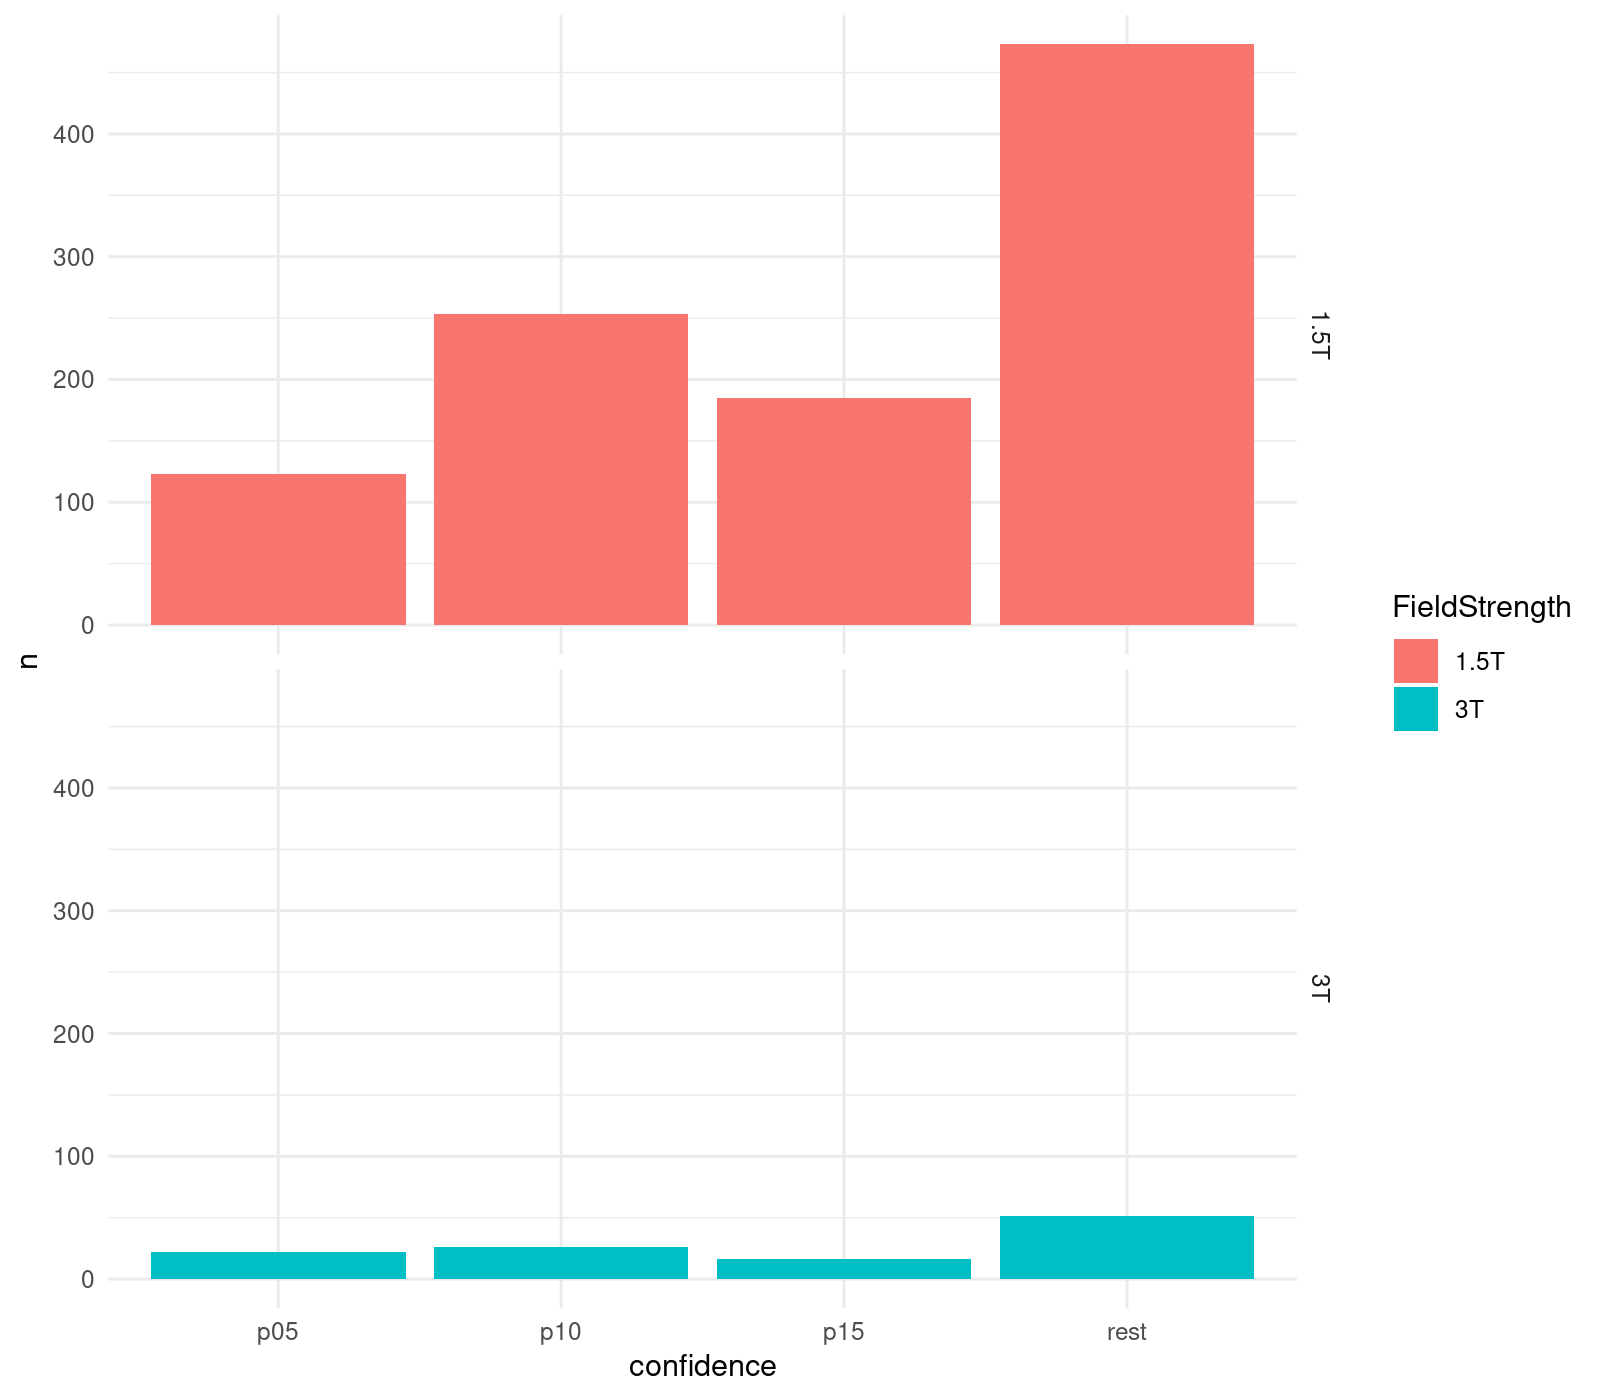

In [13]:
ggplot(
    data %>% group_by(confidence) %>% mutate(FieldStrength=str_c(MagneticFieldStrength,"T")) %>% count(FieldStrength),
    aes(confidence, n, fill=FieldStrength)) +
    geom_col(position="dodge") +
    facet_grid(FieldStrength ~ .)

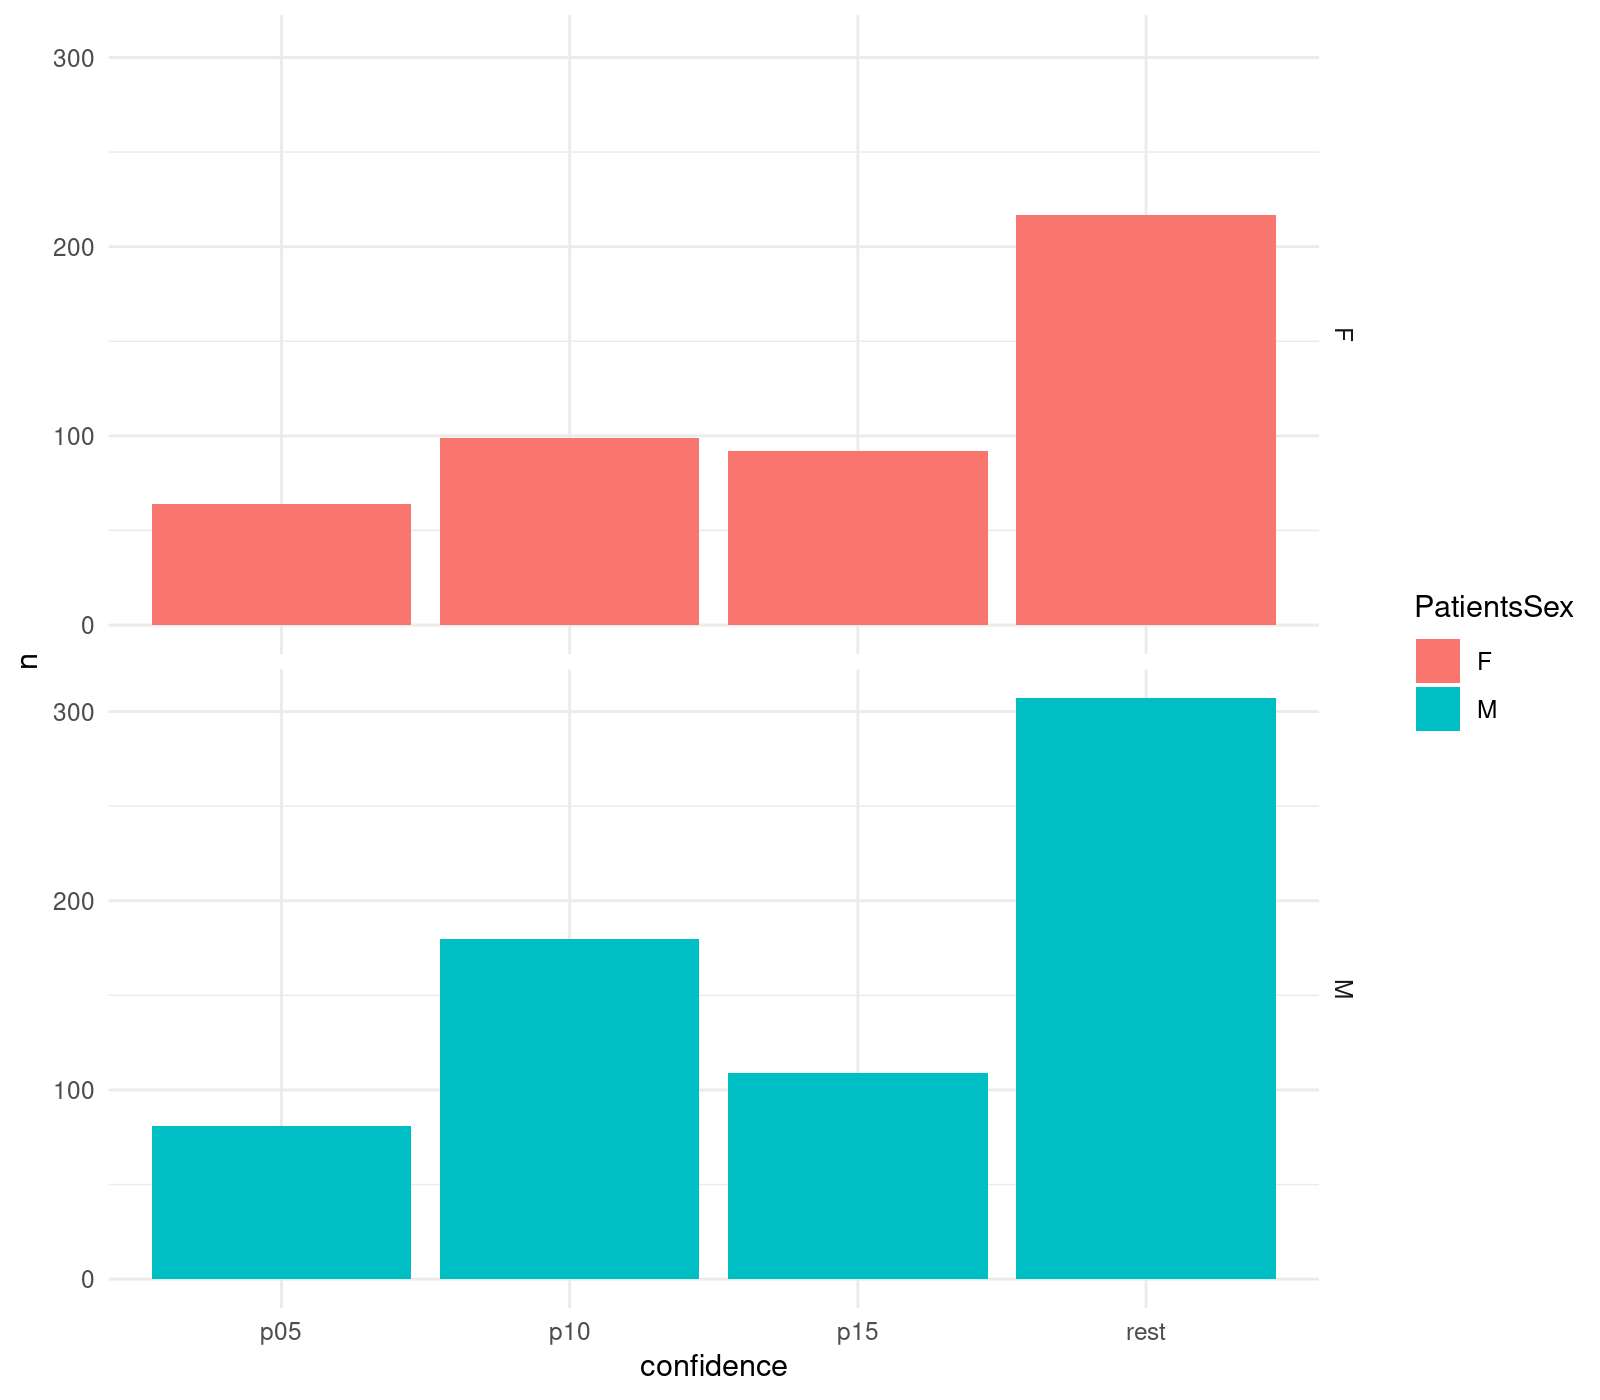

In [14]:
ggplot(
    data %>% group_by(confidence) %>% count(PatientsSex),
    aes(confidence, n, fill=PatientsSex)) +
    geom_col(position="dodge") +
    facet_grid(PatientsSex ~ .)